In [1]:
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import LeaveOneGroupOut
import dotenv
import pathlib
from mlgut.pystab import nogueria_test
from mlgut import utils
from mlgut.datasets import get_path
from mlgut.models import (
    compute_rbo_mat,
    compute_support_ebm,
    get_cp_support,
    get_lopo_support,
)

EXTENSIONS = ["pdf", "png", "svg"]

PROJECT_NAMES_DICT = {
    "PRJNA389927": "Hannigan",
    "PRJEB12449": "Vogtmann",
    "PRJEB6070": "Zeller",
    "PRJEB7774": "Feng",
    "PRJEB10878": "Yu",
    "PRJNA447983": "Thomas0",
    "PRJEB27928": "Thomas1",
}

PROJECT_ORDER = sorted(PROJECT_NAMES_DICT.values())
DISEASE_COLUMN_NAME = "DISEASE"
PROJECT_COLUMN_NAME = "SECONDARY_STUDY_ID"


def load_crossproject(condition, profile, path):
    crossproject_fname = f"{condition}_{profile}_cross_project.jbl"
    crossproject_fpath = path.joinpath(crossproject_fname)
    crossproject_results = joblib.load(crossproject_fpath)
    crossproject_results = utils.rename_keys(crossproject_results, PROJECT_NAMES_DICT)

    return crossproject_results


def load_stability(condition, profile, path):
    stability_fname = f"{condition}_{profile}_stability.jbl"
    stability_fpath = path.joinpath(stability_fname)
    stability_results = joblib.load(stability_fpath)
    stability_results = utils.rename_keys(stability_results, PROJECT_NAMES_DICT)

    return stability_results


def compute_error(results, alpha=0.05, metric="roc_auc"):
    # Z matrix in Nogueira's stability paper
    metric_str = f"test_{metric}"
    scores = np.array(results[metric_str])
    n_splits = scores.size

    mean_score = np.mean(scores)
    ci = stats.norm.ppf(1 - alpha / 2) * (np.std(scores)) / np.sqrt(n_splits)

    return scores, mean_score, ci


def compute_stability(results, alpha=0.05):
    # Z matrix in Nogueira's stability paper

    support_matrix = [
        model["selector"].get_support() * 1 for model in results["estimator"]
    ]
    support_matrix = np.array(support_matrix)

    stab_res = nogueria_test(support_matrix, alpha=alpha)
    stability = stab_res.estimator
    stability_error = stab_res.error

    return support_matrix, stability, stability_error


def analyze_stability(
    stability_results, crossproject_results, condition, profile, path
):
    stability_results_df = {
        key: compute_stability(stability_results[key])[1:]
        for key in stability_results.keys()
    }
    stability_results_df = pd.DataFrame(
        stability_results_df, index=["estability", "error"]
    )
    stability_results_df = stability_results_df.T.sort_index()

    crossproject_results_df = {
        key: compute_stability(crossproject_results[key]["cv"])[1:]
        for key in crossproject_results.keys()
    }
    crossproject_results_df = pd.DataFrame(
        crossproject_results_df, index=["estability", "error"]
    )
    crossproject_results_df = crossproject_results_df.T.sort_index()

    roc_auc_stability = {
        key: compute_error(stability_results[key])[0]
        for key in stability_results.keys()
    }

    roc_auc_stability = pd.DataFrame(roc_auc_stability).melt(
        value_name="Mean AUROC", var_name="Project"
    )

    roc_auc_crossproject = {
        key: compute_error(crossproject_results[key]["cv"])[0]
        for key in crossproject_results.keys()
    }
    roc_auc_crossproject = pd.DataFrame(roc_auc_crossproject).melt(
        value_name="Mean AUROC", var_name="Project"
    )

    plot_stability(
        crossproject_results_df, stability_results_df, condition, profile, path
    )
    plot_error(roc_auc_crossproject, roc_auc_stability, condition, profile, path)

    return roc_auc_crossproject


def plot_stability(cp_df, stab_df, condition, profile, path):
    plt.style.use("fivethirtyeight")
    _, ax = plt.subplots(1, 1, figsize=(16, 9))
    plt.errorbar(
        x=cp_df.index,
        y=cp_df["estability"],
        yerr=cp_df["error"],
        label=["CV-stability"],
    )
    plt.errorbar(
        x=stab_df.index,
        y=stab_df["estability"],
        yerr=stab_df["error"],
        label=["RSSS-stability"],
    )
    ax.set_xlabel("Project")
    ax.set_ylabel("Stability")
    plt.legend(loc="lower right")
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_feature_selection_stability.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def plot_error(cp_df, stab_df, condition, profile, path):
    _, ax = plt.subplots(1, 1, figsize=(16, 9))

    sns.lineplot(
        x="Project",
        y="Mean AUROC",
        data=cp_df,
        ax=ax,
        err_style="bars",
        ci=95,
        label="CV-test",
    )
    sns.lineplot(
        x="Project",
        y="Mean AUROC",
        data=stab_df,
        ax=ax,
        err_style="bars",
        ci=95,
        label="RSSS-test",
    )
    plt.legend(loc="lower right")
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_feature_selection_stability_error.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def analyze_rank_stability(results, features, profile, condition, path):
    def compute_ebm_fi_by_project(results, key):
        ebm_fi_list = [
            pd.Series(compute_support_ebm(model)[1], index=features.columns)
            for model in results[key]["cv"]["estimator"]
        ]
        ebm_fi = pd.concat(ebm_fi_list, axis=1)

        return ebm_fi

    ebm_fi_by_project = {
        key: compute_ebm_fi_by_project(results, key) for key in results.keys()
    }

    dmat = {
        key: compute_rbo_mat(ebm_fi_by_project[key]) for key in ebm_fi_by_project.keys()
    }

    dmat = pd.DataFrame(dmat).melt(value_name="dRBO", var_name="Project")
    fname = f"{condition}_{profile}_rank_stability_mat.jbl"
    fpath = path.joinpath(fname)
    joblib.dump(dmat, fpath)

    plt.figure(figsize=(16, 9))
    sns.violinplot(x="Project", y="dRBO", data=dmat, order=PROJECT_ORDER)
    plt.ylim([-0.1, 1.1])
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_rank_stability.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def analyze_lopo_wo_oracle(results, features, metadata, profile, condition, control):
    query = metadata[DISEASE_COLUMN_NAME].isin([control, condition])
    projects = metadata.loc[query, PROJECT_COLUMN_NAME]

    lopo_mean = dict(zip(np.unique(projects), results["test_roc_auc"]))
    lopo_mean = utils.rename_keys(lopo_mean, PROJECT_NAMES_DICT)

    _, support_merged = get_lopo_support(results, features.columns)

    print(lopo_mean, np.mean(results["test_roc_auc"]))

    return lopo_mean, support_merged


def analyze_lopo_with_oracle(results, metadata, profile, condition, control):
    query = metadata[DISEASE_COLUMN_NAME].isin([control, condition])
    projects = metadata.loc[query, PROJECT_COLUMN_NAME]

    best = 0.0
    keep = {}
    best_support = []
    for i in results.keys():
        # top: at least in `i` LOPO trainings.
        lopo_mean_i = dict(zip(np.unique(projects), results[i]["cv"]["test_roc_auc"]))
        mean_i = np.mean(results[i]["cv"]["test_roc_auc"])
        lopo_mean_i = utils.rename_keys(lopo_mean_i, PROJECT_NAMES_DICT)
        if mean_i > best:
            best = mean_i
            keep = lopo_mean_i
            columns = results[i]["columns"]
            _, best_support = get_lopo_support(results[i]["cv"], columns)

        print(lopo_mean_i, mean_i)

    return keep, best_support


def plot_lopo(frame, support, profile, condition, path, oracle=True):
    if oracle:
        with_str = "with"
    else:
        with_str = "wo"
    print(frame)
    fname = f"{condition}_{profile}_lopo_{with_str} _oracle_support.tsv"
    fpath = path.joinpath(fname)
    support.to_csv(fpath, sep="\t")


def get_cross_project_data(names, profile, condition, results):

    l = []
    for project_id in results.keys():
        r = results[project_id]["outer"][
            [PROJECT_COLUMN_NAME, DISEASE_COLUMN_NAME, "decission"]
        ].copy()
        r[PROJECT_COLUMN_NAME] = r[PROJECT_COLUMN_NAME].replace(PROJECT_NAMES_DICT)
        r = r.groupby(PROJECT_COLUMN_NAME).apply(
            lambda x: metrics.roc_auc_score(
                x[DISEASE_COLUMN_NAME] == condition, x["decission"]
            )
        )
        r.name = project_id
        l.append(r)

    r = pd.concat(l, axis=1).T
    for project_id in results.keys():
        r.loc[project_id, project_id] = np.mean(
            results[project_id]["cv"]["test_roc_auc"]
        )

    fi, fi_merged = get_cp_support(results, names)

    return r, fi, fi_merged


def build_scoring_mat(cp_mat, lopo_wo_oracle, lopo_with_oracle):

    mat = cp_mat.copy()
    mat = mat.loc[PROJECT_ORDER, PROJECT_ORDER]
    mat.loc["Mean", :] = mat.mean(axis=0)
    lopo_wo_oracle_series = pd.Series(lopo_wo_oracle, name="LOPO")
    lopo_with_oracle_series = pd.Series(lopo_with_oracle, name="oLOPO")
    mat = mat.append(lopo_wo_oracle_series)
    mat = mat.append(lopo_with_oracle_series)
    mat["Mean"] = mat.mean(axis=1)

    return mat


def plot_scores(mat, condition, profile, path):

    plt.figure()
    ax = sns.heatmap(
        mat,
        annot=True,
        fmt=".2f",
        vmin=0.0,
        vmax=1.0,
        cbar=False,
        xticklabels=True,
        yticklabels=True,
    )
    ax.xaxis.set_ticks_position("top")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_score_matrix.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def load_lopo(condition, profile, path, oracle=False):
    if oracle:
        with_str = "with"
    else:
        with_str = "wo"

    fname = f"{condition}_{profile}_lopo_{with_str}_oracle.jbl"
    fpath = path.joinpath(fname)
    results = joblib.load(fpath)

    return results


def build_analysis(features, metadata, profile, condition, control, path):
    results_stab = load_stability(condition, profile, path)
    results_cp = load_crossproject(condition, profile, path)
    results_lopo_wo_oracle = load_lopo(condition, profile, path, oracle=False)
    results_lopo_with_oracle = load_lopo(condition, profile, path, oracle=True)

    metadata_ = metadata.copy()
    metadata_[PROJECT_COLUMN_NAME] = metadata_[PROJECT_COLUMN_NAME].replace(
        PROJECT_NAMES_DICT
    )

    cp_mat, cp_fi, cp_fi_merged = get_cross_project_data(
        features.columns, profile, condition, results_cp
    )
    cp_fi.to_csv(path.joinpath(f"{condition}_{profile}_cp_support.tsv"), sep="\t")
    cp_fi_merged.to_csv(
        path.joinpath(f"{condition}_{profile}_cp_support_merge.tsv"), sep="\t"
    )

    lopo_wo_oracle, support_lopo_wo_oracle = analyze_lopo_wo_oracle(
        results_lopo_wo_oracle, features, metadata, profile, condition, control
    )
    lopo_with_oracle, support_lopo_with_oracle = analyze_lopo_with_oracle(
        results_lopo_with_oracle, metadata, profile, condition, control
    )

    score_mat = build_scoring_mat(cp_mat, lopo_wo_oracle, lopo_with_oracle)
    plot_scores(score_mat, condition, profile, path)

    plot_lopo(
        lopo_wo_oracle, support_lopo_wo_oracle, profile, condition, path, oracle=False
    )
    plot_lopo(
        lopo_with_oracle,
        support_lopo_with_oracle,
        profile,
        condition,
        path,
        oracle=True,
    )

    analyze_stability(results_stab, results_cp, condition, profile, path)
    analyze_rank_stability(results_cp, features, profile, condition, path)
    
def compute_support_ebm(model, quantile=None):
    # TODO: check if trained
    ebm = model["estimator"]
    ebm_global = ebm.explain_global()
    data = ebm_global.data()

    if "selector" in model.named_steps.keys():
        support = model["selector"].get_support()
    else:
        support = np.repeat(True, len(data["scores"]))

    coefs = np.zeros(support.size)
    coefs[support] = np.array(data["scores"])

    support = support * 1

    return support, coefs

from scipy.stats import linregress, rankdata, weightedtau

def fdr(p_vals):
    ranked_p_values = rankdata(p_vals)
    p_vals_new = p_vals * len(p_vals) / ranked_p_values
    p_vals_new[p_vals_new > 1] = 1

    return p_vals_new

def compute_explanations(pipe, X, name, folder_path, profile_name, conditon="crc"):
    from sklearn.pipeline import Pipeline
    X_trans = Pipeline(pipe.steps[:-1]).transform(features)    
    X_filt = pd.DataFrame(X_trans, index=X.index, columns=X.columns[pipe["selector"].get_support()])
    
    model = pipe["estimator"]
    ebm_local = model.explain_local(X_filt)

    explanations = [ebm_local.data(irow) for irow in range(X_filt.shape[0])]
    explanation_df = pd.concat(
        [pd.Series(x["scores"], index=X_filt.columns, name="score") for x in explanations],
        axis=1,
    )
    explanation_df.columns = X_filt.index
    explanation_df = explanation_df.T

    explanations_reg = [
        linregress(X[col], explanation_df[col]) for col in X_filt.columns
    ]
    explanations_coef = pd.Series(
        [reg[0] for reg in explanations_reg], index=X_filt.columns, name="r_coeff"
    )
    explanations_sig = pd.Series(
        [coef > 0 for coef in explanations_coef], index=X_filt.columns, name="r_sign"
    )
    explanations_pval = pd.Series(
        [reg[3] for reg in explanations_reg], index=X_filt.columns, name="r_pvalue"
    )
    explanations_pval_fdr = pd.Series(
        fdr(explanations_pval), index=X_filt.columns, name="r_pvalue_fdr"
    )

    explanations_rank = explanation_df.abs().mean()
    explanations_rank.name = "score"
    explanations_analysis = pd.concat(
        (explanations_rank, explanations_coef, explanations_sig, explanations_pval, explanations_pval_fdr),
        axis=1,
    )
    
    explanations_analysis = explanations_analysis.sort_values(by="score", ascending=False)

    dataset_fpath = folder_path.joinpath(
        f"{condition}_{profile_name}_{name}_explanations.tsv"
    )
    explanations_analysis.to_csv(dataset_fpath, sep="\t", index_label="feature_id")
    
    return explanations_analysis

def build_support_and_score_mat(condition, control, profile, features, metadata, results_cp, results_lopo_wo_oracle, results_lopo_with_oracle):   
    print(f"start {profile}")
    metadata_ = metadata.copy()
    metadata_[PROJECT_COLUMN_NAME] = metadata_[PROJECT_COLUMN_NAME].replace(
        PROJECT_NAMES_DICT
    )

    cp_mat, cp_fi, cp_fi_merged = get_cross_project_data(
        features.columns, profile, condition, results_cp
    )
#     cp_fi.to_csv(path.joinpath(f"{condition}_{profile}_cp_support.tsv"), sep="\t")
#     cp_fi_merged.to_csv(
#         path.joinpath(f"{condition}_{profile}_cp_support_merge.tsv"), sep="\t"
#     )

    lopo_wo_oracle, support_lopo_wo_oracle = analyze_lopo_wo_oracle(
        results_lopo_wo_oracle, features, metadata, profile, condition, control
    )
    lopo_with_oracle, support_lopo_with_oracle = analyze_lopo_with_oracle(
        results_lopo_with_oracle, metadata, profile, condition, control
    )

    score_mat = build_scoring_mat(cp_mat, lopo_wo_oracle, lopo_with_oracle)
    
    print(f"end {profile}")
    
    return score_mat

In [2]:
project_path = pathlib.Path(dotenv.find_dotenv()).parent
results_path = project_path.joinpath("data", "paper")

In [3]:
condition = "CRC"
profile = "centrifuge"
ext="jbl"
profile_names = ["centrifuge", "KEGG_KOs", "OGs"]
EXTRACT = False

In [4]:
profile_rename_dict = {
    "centrifuge": "Taxonomic",
    "KEGG_KOs": "Kegg",
    "OGs": "EggNog"
}

analysis_rename_dict = {
    "CV-Stability": "CV-test",
    "RSSS-Stability": "RSSS-test"
}

project_plot_names = {
    "Hannigan": "Hannigan\nn = 82",
    "Vogtmann": "Vogtmann\nn = 104",
    "Zeller": "Zeller\nn = 199",
    "Feng": "Feng\nn = 132",
    "Yu": "Yu\nn = 128",
    "Thomas0": "Thomas0\nn = 124",
    "Thomas1": "Thomas1\nn = 82",
}

replace_dict = {**profile_rename_dict, **analysis_rename_dict}

In [5]:
project_plot_names = {
    "Hannigan": "Hannigan\nn = 82",
    "Vogtmann": "Vogtmann\nn = 104",
    "Zeller": "Zeller\nn = 199",
    "Feng": "Feng\nn = 132",
    "Yu": "Yu\nn = 128",
    "Thomas0": "Thomas0\nn = 124",
    "Thomas1": "Thomas1\nn = 82",
    "Mean": "Mean",
    "LOPO": "LOPO",
    "oLOPO": "oLOPO"
}

COLOR_BLIND_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73",
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Load data

In [6]:
if EXTRACT:
    stab_df = pd.DataFrame()
    results_stab_dict = {}
    results_cp_dict = {}

    for profile in profile_names:
        print(profile)
        path = results_path.joinpath(f"{condition.lower()}_{profile.lower()}_results")

        results_stab = load_stability(condition, profile, path)
        results_stab_dict[profile] = results_stab

        results_cp = load_crossproject(condition, profile, path)
        results_cp_dict[profile] = results_cp
        print(f"end {profile}")

In [7]:
if EXTRACT:
    results_lopo_wo_oracle_dict = {}
    results_lopo_with_oracle_dict = {}

    for profile in profile_names:
        print(profile)
        path = results_path.joinpath(f"{condition.lower()}_{profile.lower()}_results")

        results_lopo_wo_oracle = load_lopo(condition, profile, path, oracle=False)
        results_lopo_wo_oracle_dict[profile] = results_lopo_wo_oracle

        results_lopo_with_oracle = load_lopo(condition, profile, path, oracle=True)
        results_lopo_with_oracle_dict[profile] = results_lopo_with_oracle
        print(f"end {profile}")    

In [8]:
if EXTRACT:
    features_dict = {}
    metadata_dict = {}
    condition = "CRC"

    from mlgut import datasets

    for profile in profile_names:
        print(f"start {profile}") 
        features, metadata = datasets.build_condition_dataset(
            condition, profile, ext="jbl"
        )
        if "ogs" in profile.lower():
            features = datasets.filter_egg(features)
        if "cent" in profile.lower():
            tax_id = "9606"
            features = features.drop(tax_id, axis=1)
        features_dict[profile] = features
        metadata_dict[profile] = metadata
        print(f"end {profile}")   

# Cross-Project scores

In [9]:
cp_mat_fpath = results_path.joinpath("combined", "cp_mat_dict.jbl")
if EXTRACT:
    cp_mat_dict = {
        profile_name: build_support_and_score_mat(condition="CRC", 
                                                  control="healthy",
                                                  profile=profile_name,
                                                  features=features_dict[profile_name],
                                                  metadata=metadata_dict[profile_name],
                                                  results_cp=results_cp_dict[profile_name],
                                                  results_lopo_wo_oracle=results_lopo_wo_oracle_dict[profile_name],
                                                  results_lopo_with_oracle=results_lopo_with_oracle_dict[profile_name]
                                   )
        for profile_name in profile_names
    }
    joblib.dump(cp_mat_dict, cp_mat_fpath)
else:
    cp_mat_dict = joblib.load(cp_mat_fpath)

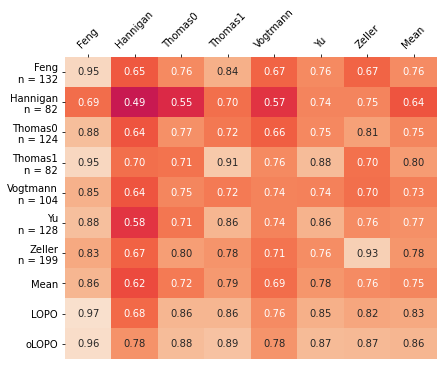

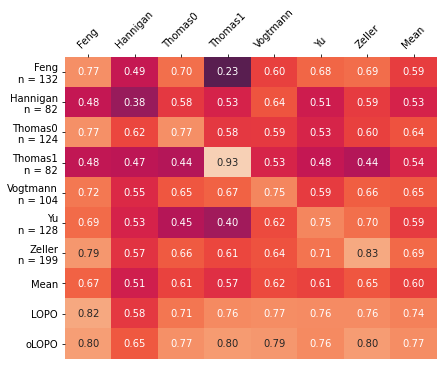

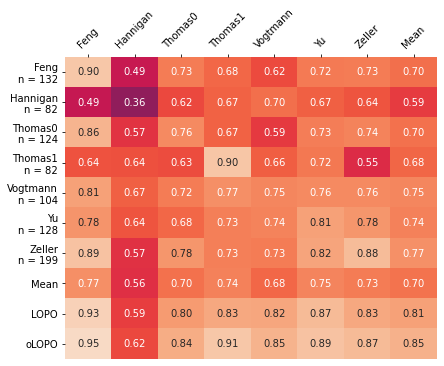

In [10]:
profile_name = profile_names[0]

condition = "crc"
for profile_name in profile_names:
    mat = cp_mat_dict[profile_name]

    fac = 1.8
    plt.subplots(1, 1, figsize=(12/fac, 10/fac));

    ax = sns.heatmap(
        mat,
        annot=True,
        fmt=".2f",
        vmin=0.0,
        vmax=1.0,
        cbar=False,
        xticklabels=True,
        yticklabels=True,
    );
    ax.xaxis.set_ticks_position("top");
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
    labels = [item.get_text() for item in ax.get_yticklabels()];
    labels_new = [project_plot_names[label] for label in labels];
    ax.set_yticklabels(labels_new);

    for ext in EXTENSIONS:
        fname = f"{condition}_{profile_name}_score_matrix.{ext}".lower()
        fpath = results_path.joinpath("combined", fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
        #if ext == "svg":  
        fpath = project_path.joinpath("figures", fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.show()
plt.close("all")

In [11]:
import seaborn as sns

sns.set_context("paper")
sns.set_palette("colorblind")

# Stability analysis

In [12]:
if EXTRACT:
    stab_df = pd.DataFrame()

    for profile in profile_names:
        print(profile)

        results_stab = results_stab_dict[profile]
        results_cp = results_cp_dict[profile]

        cp_stab_mat = [(project, *compute_stability(results_cp[project]["cv"], alpha=0.05)[1:]) for project in results_cp.keys()]
        cp_stab_df = pd.DataFrame(cp_stab_mat, columns=["Project", "Stability", "Error"])
        cp_stab_df["Analysis"] = "CV-Stability"
        cp_stab_df["Profile"] = profile

        st_stab_mat = [(project, *compute_stability(results_stab[project], alpha=0.05)[1:]) for project in results_stab.keys()]
        st_stab_df = pd.DataFrame(st_stab_mat, columns=["Project", "Stability", "Error"])
        st_stab_df["Analysis"] = "RSSS-Stability"
        st_stab_df["Profile"] = profile

        stab_df_i = pd.concat((cp_stab_df, st_stab_df), axis=0)
        stab_df = pd.concat((stab_df, stab_df_i), axis=0)
        
        stab_df = stab_df.replace(replace_dict)
        stab_df["up"] = stab_df["Stability"] + stab_df["Error"]
        stab_df["low"] = stab_df["Stability"] - stab_df["Error"]
        
        stab_df.to_csv(results_path.joinpath("combined", f"stability_results_summary.tsv.gz"), sep="\t")
else:
    stab_df = pd.read_csv(results_path.joinpath("combined", f"stability_results_summary.tsv.gz"), sep="\t")
    
stab_df.head()

,Project,Stability,Error,Analysis,Profile,up,low
0,Vogtmann,0.645396,0.005995,CV-test,Taxonomic,0.651390,0.639401
1,Thomas1,0.709563,0.004632,CV-test,Taxonomic,0.714195,0.704931
2,Zeller,0.788261,0.003323,CV-test,Taxonomic,0.791584,0.784938
3,Feng,0.751641,0.006976,CV-test,Taxonomic,0.758617,0.744664
4,Yu,0.724036,0.004924,CV-test,Taxonomic,0.728961,0.719112


In [13]:
stab_df_plot = stab_df.copy()
stab_df_plot = stab_df_plot.replace(project_plot_names)

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_stability_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/b

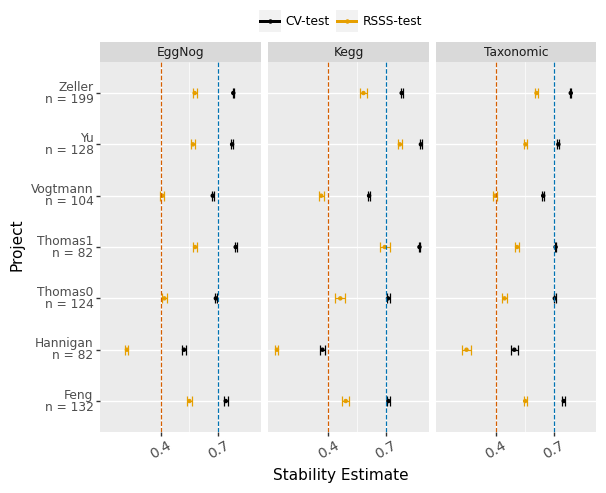

<ggplot: (2995682715033)>

In [14]:
from plotnine import scale_x_continuous, geom_vline, ggsave, theme, element_text, scale_color_discrete, ggplot, aes
import plotnine as gg


fname = "stability"
g = (
    ggplot(stab_df_plot)
    + gg.facet_wrap("~Profile")
    + gg.aes(x="Stability", y="Project", color="Analysis")
    + gg.labs(
        x="Stability Estimate",
        y="Project"    )
    + gg.geom_point(size=0.8)
    + gg.xlim(0.2, 1.0)
    + gg.scale_x_continuous(breaks=[0.4, 0.7])
    + gg.geom_errorbarh(aes(xmin="low", xmax="up"), height=0.2)
    + gg.geom_vline(xintercept=0.4, linetype="dashed", color=COLOR_BLIND_PALETTE[-2])
    + gg.geom_vline(xintercept=0.7, linetype="dashed", color=COLOR_BLIND_PALETTE[-3])
   + gg.theme(axis_text_y=element_text(size=10, hjust=-1))
    + gg.theme_gray()
    + gg.theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + gg.theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
     
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)


g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.pdf"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.svg"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.png"), dpi=300)
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.png"), dpi=300)
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.svg"))
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.pdf"))
g

# Intra project score analysis

In [15]:
if EXTRACT:

    err_df = pd.DataFrame()

    for profile in profile_names:
        print(profile)

        results_stab = results_stab_dict[profile]
        results_cp = results_cp_dict[profile]

        cp_err_mat = [(project, *compute_error(results_cp[project]["cv"], alpha=0.05)[1:]) for project in results_cp.keys()]
        cp_err_df = pd.DataFrame(cp_err_mat, columns=["Project", "AUROC", "Error"])
        cp_err_df["Analysis"] = "CV-Stability"
        cp_err_df["Profile"] = profile

        st_err_mat = [(project, *compute_error(results_stab[project], alpha=0.05)[1:]) for project in results_stab.keys()]
        st_err_df = pd.DataFrame(st_err_mat, columns=["Project", "AUROC", "Error"])
        st_err_df["Analysis"] = "RSSS-Stability"
        st_err_df["Profile"] = profile

        err_df_i = pd.concat((cp_err_df, st_err_df), axis=0)
        err_df = pd.concat((err_df, err_df_i), axis=0)
        
        err_df = err_df.replace(replace_dict)
        err_df["up"] = err_df["AUROC"] + err_df["Error"]
        err_df["low"] = err_df["AUROC"] - err_df["Error"]
        
        err_df.to_csv(results_path.joinpath("combined", f"scoring_results_summary.tsv.gz"), sep="\t")
else:
    err_df = pd.read_csv(results_path.joinpath("combined", f"scoring_results_summary.tsv.gz"), sep="\t")
        
err_df.head()

,Project,AUROC,Error,Analysis,Profile,up,low
0,Vogtmann,0.738400,0.021227,CV-test,Taxonomic,0.759627,0.717173
1,Thomas1,0.909167,0.019336,CV-test,Taxonomic,0.928503,0.889831
2,Zeller,0.926786,0.009483,CV-test,Taxonomic,0.936268,0.917303
3,Feng,0.948000,0.014730,CV-test,Taxonomic,0.962730,0.933270
4,Yu,0.855250,0.015090,CV-test,Taxonomic,0.870340,0.840160


/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_auroc_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babel

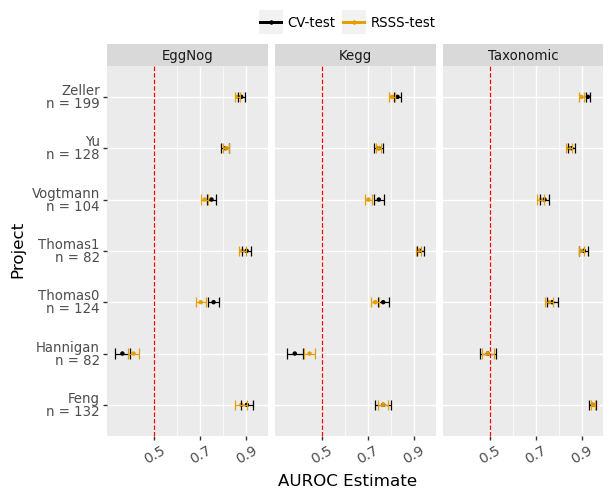

<ggplot: (2995683603801)>

In [16]:
from plotnine import scale_x_continuous, geom_vline, ggsave, theme, element_text, scale_color_discrete
import plotnine as gg

panel_col = "antiquewhite"

score_name = "AUROC"
fname = "auroc"

X = err_df.replace(project_plot_names)

g = (
    ggplot(X)
    + gg.facet_wrap("~Profile")
    + gg.aes(x=score_name, y="Project", color="Analysis")
    + gg.labs(
        x="AUROC Estimate",
        y="Project"    )
    + gg.geom_point(size=0.8)
    + gg.xlim(0.2, 1.0)
    + gg.scale_x_continuous(breaks=[0.5, 0.7, 0.9])
    + gg.geom_errorbarh(aes(xmin="low", xmax="up"), height=0.2)
    + gg.geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray(base_size=12)
    + gg.theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + gg.theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)

g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.pdf"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.svg"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.png"), dpi=300)
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.png"), dpi=300)
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.svg"))
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.pdf"))
g

# Rank stability analysis

In [17]:
if EXTRACT:
    kegg_explanations = {}
    profile = "KEGG_KOs"
    features, metadata = datasets.build_condition_dataset(
        condition="CRC", profile_name=profile, ext="jbl"
    )

    for project in PROJECT_NAMES_DICT.values():
        explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
        explanations = pd.concat(explanations, axis=1)
        kegg_explanations[project] = explanations

    taxo_explanations = {}
    profile="centrifuge"
    features, metadata = datasets.build_condition_dataset(
        condition="CRC", profile_name=profile, ext="jbl"
    )
    features = datasets.filter_egg(features)
    tax_id = "9606"
    print(tax_id in features.columns)
    features = features.drop(tax_id, axis=1)
    for project in PROJECT_NAMES_DICT.values():
        explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
        explanations = pd.concat(explanations, axis=1)
        taxo_explanations[project] = explanations

    ogs_explanations = {}
    profile="OGs"
    features, metadata = datasets.build_condition_dataset(
        condition="CRC", profile_name=profile, ext="jbl"
    )
    features = datasets.filter_egg(features)
    for project in PROJECT_NAMES_DICT.values():
        explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
        explanations = pd.concat(explanations, axis=1)
        ogs_explanations[project] = explanations

    explanations = kegg_explanations
    wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
    for project in PROJECT_ORDER:
        wtau = []
        for i in range(explanations[project].shape[1]):
            for j in range(i+1, explanations[project].shape[1]):
                wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
        wtau_df[project] = wtau

    kegg_wtau = wtau_df
    kegg_wtau["Profile"] = "Kegg"
    kegg_wtau.plot(kind="box", figsize=(16/2, 9/2))

    explanations = ogs_explanations
    wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
    for project in ["Zeller"]:
        wtau = []
        for i in range(explanations[project].shape[1]):
            for j in range(i+1, explanations[project].shape[1]):
                wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
        wtau_df[project] = wtau
    egg_wtau = wtau_df
    egg_wtau["Profile"] = "eNog"
    egg_wtau.plot(kind="box", figsize=(16/2, 9/2))

    explanations = taxo_explanations
    wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
    for project in PROJECT_ORDER:
        wtau = []
        for i in range(explanations[project].shape[1]):
            for j in range(i+1, explanations[project].shape[1]):
                wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
        wtau_df[project] = wtau

    taxo_wtau = wtau_df
    taxo_wtau["Profile"] = "Taxo"
    taxo_wtau.plot(kind="box", figsize=(16/2, 9/2))

    taxo_wtau = wtau_df
    taxo_wtau["Profile"] = "Taxo"
    taxo_wtau.plot(kind="box", figsize=(16/2, 9/2))

    wtau_df = pd.concat((kegg_wtau, egg_wtau, taxo_wtau), axis=0)
    wtau_df = wtau_df.melt(id_vars=["Profile"], var_name="Project", value_name="Score")

    wtau_df = wtau_df.replace({"Kegg": "Kegg", "Taxo": "Taxonomic", "eNog": "eggNog"})

    condition = "CRC"
    profile = "centrifuge"

    projects = metadata.PROJECT.copy()
    projects = projects.replace(PROJECT_NAMES_DICT)

    taxo_explanations_stab = {}
    profile="centrifuge"
    features, metadata = datasets.build_condition_dataset(
        condition="CRC", profile_name=profile, ext="jbl"
    )
    tax_id = "9606"
    print(tax_id in features.columns)
    features = features.drop(tax_id, axis=1)
    for project in PROJECT_NAMES_DICT.values():
        print(f"start {project}")
        explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
        explanations = pd.concat(explanations, axis=1)
        taxo_explanations_stab[project] = explanations
        print(f"finished {project}")
    joblib.dump(taxo_explanations_stab, "taxo_stab_explanation.jbl")

    kegg_explanations_stab = {}
    profile="KEGG_KOs"
    features, metadata = datasets.build_condition_dataset(
        condition="CRC", profile_name=profile, ext="jbl"
    )
    features = datasets.filter_egg(features)
    for project in PROJECT_NAMES_DICT.values():
        print(f"start {project}")
        explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
        explanations = pd.concat(explanations, axis=1)
        kegg_explanations_stab[project] = explanations
        print(f"finished {project}")
    joblib.dump(kegg_explanations_stab, "kegg_stab_explanation.jbl")

    ogs_explanations_stab = {}
    profile="OGs"
    features, metadata = datasets.build_condition_dataset(
        condition="CRC", profile_name=profile, ext="jbl"
    )
    features = datasets.filter_egg(features)
    for project in PROJECT_NAMES_DICT.values():
        print(f"start {project}")
        explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
        explanations = pd.concat(explanations, axis=1)
        ogs_explanations_stab[project] = explanations
        print(f"finished {project}")
    joblib.dump(ogs_explanations_stab, "ogs_stab_explanation.jbl")

    profiles = ["Taxonomic", "eggNog", "Kegg"]

    df = pd.DataFrame(columns=PROJECT_ORDER + ["Profile"])

    for profile in profiles:
        print(f"start profile {profile}")
        if profile == "Taxonomic":
            explanations = taxo_explanations_stab
        elif profile == "Kegg":
            explanations = kegg_explanations_stab
        elif profile == "eggNog":
            explanations = º
        df_i = pd.DataFrame(columns=PROJECT_ORDER)
        for project in PROJECT_ORDER:
            print(f"start project {project}")
            wtau = []
            for i in range(explanations[project].shape[1]):
                for j in range(i+1, explanations[project].shape[1]):
                    wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
            df_i[project] = wtau
            print(f"end project {project}")
        df_i["Profile"] = profile
        df = pd.concat((df, df_i), axis=0)
        print(f"end profile {profile}")
        print("")
    df["Analysis"] = "RSSS-test"
    stab_rank = df.copy()
    cv_rank = pd.concat((kegg_wtau, egg_wtau, taxo_wtau), axis=0).copy().replace({"Kegg": "Kegg", "Taxo": "Taxonomic", "eNog": "eggNog"})
    cv_rank["Analysis"] = "CV-test" 
    rank_df = pd.concat((cv_rank, stab_rank), axis=0)
    rank_df.to_csv("rank.tsv", sep="\t", index=False)
    df = rank_df.melt(id_vars=["Profile", "Analysis"], var_name="Project", value_name="Score")
    X = df.groupby(["Profile", "Analysis", "Project"])["Score"].describe()[["mean", "25%", "75%"]].reset_index()
    X.to_csv(results_path.joinpath("combined", "crc_rank_summary.tsv"), sep="\t", index=False)
else:
    tsv_path = results_path.joinpath("combined", "crc_rank_summary.tsv")
    X = pd.read_csv(tsv_path, sep="\t")
    X = X.replace(project_plot_names)
X.head()

,Profile,Analysis,Project,mean,25%,75%
0,Kegg,CV-test,Feng\nn = 132,0.812402,0.784553,0.843475
1,Kegg,CV-test,Hannigan\nn = 82,0.609697,0.554479,0.671614
2,Kegg,CV-test,Thomas0\nn = 124,0.793874,0.767615,0.824959
3,Kegg,CV-test,Thomas1\nn = 82,0.855509,0.835683,0.878276
4,Kegg,CV-test,Vogtmann\nn = 104,0.777110,0.754314,0.804643


/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_rank_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelo

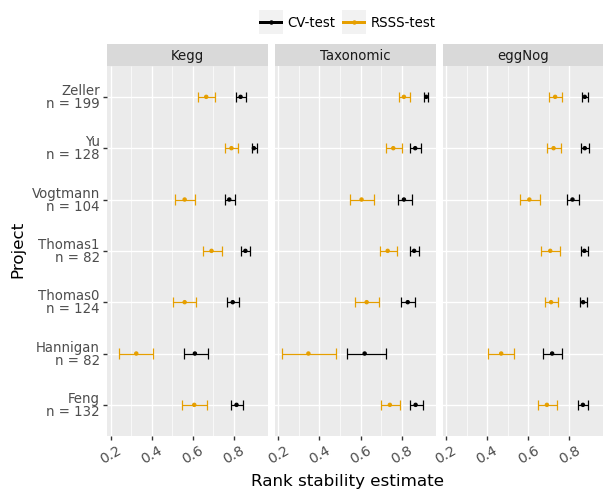

<ggplot: (2995684127101)>

In [18]:
from plotnine import scale_x_continuous, geom_vline, ggsave, theme, element_text, scale_color_discrete
import plotnine as gg

panel_col = "antiquewhite"

score_name = "mean"
fname = "rank"
xlab_str = "Rank stability estimate"

g = (
    ggplot(X)
    + gg.facet_wrap("~Profile")
    + gg.aes(x=score_name, y="Project", color="Analysis")
    + gg.labs(
        x=xlab_str,
        y="Project"    
    )
    + gg.geom_point(size=0.8)
    + gg.xlim(0.2, 1.0)
    + gg.scale_x_continuous(breaks=[0.2, 0.4, 0.6, 0.8])
    + gg.geom_errorbarh(aes(xmin="25%", xmax="75%"), height=0.2)
    #+ gg.geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray(base_size=12)
    + gg.theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + gg.theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)

g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.pdf"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.svg"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.png"), dpi=300)
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.png"), dpi=300)
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.svg"))
g.save(project_path.joinpath("figures", f"crc_{fname}_analysis.pdf"))
g

# Adenoma

In [19]:
results = {}
condition = "CRC"
for profile_name in ["KEGG_KOs", "centrifuge", "OGs"]:
    name = f"{condition}_{profile_name}_adenoma_mwtest.jbl"
#     path = results_path.joinpath(f"{condition}_{profile_name}_results".lower(), name)
    path = results_path.joinpath(f"{condition.lower()}_{profile_name.lower()}_results", name)
    if profile_name == "kcentrifuge":
        results[profile_name] = adenoma_mwtest
    else:
        results[profile_name] = joblib.load(path)
        

In [20]:
test = "healthy_l_adenoma"
dfs = []
alpha_sig = 0.05

for test in results[list(results.keys())[0]].keys():
    if test == "small_l_healthy":
        continue
    df = pd.DataFrame()
    for profile_name in results.keys():
        try:
            df[profile_name] = [x[-1] for x in results[profile_name][test]]
            df[profile_name]  = df[profile_name] < alpha_sig
        except:
            df[profile_name] = np.nan
    df["test"] = test
    dfs.append(df)

df = pd.concat(dfs, axis=0)
df.head()

,KEGG_KOs,centrifuge,OGs,test
0,False,True,False,healthy_l_small
1,False,False,False,healthy_l_small
2,False,False,False,healthy_l_small
3,False,False,False,healthy_l_small
4,False,False,False,healthy_l_small


In [21]:
df = df.groupby("test").agg(sum).T.reset_index()
df["healthy_l_crc"] = 100.0
df

test,index,adenoma_l_crc,healthy_l_adenoma,healthy_l_small,small_l_adenoma,healthy_l_crc
0,KEGG_KOs,68.0,100.0,0.0,85.0,100.0
1,centrifuge,100.0,47.0,52.0,0.0,100.0
2,OGs,100.0,100.0,5.0,100.0,100.0


In [22]:
df = df.rename(
    columns={"healthy_l_adenoma": "H < A",
             "adenoma_l_crc": "A < T",
             "small_l_adenoma": "S < A",
             "healthy_l_small": "H < S",
             "healthy_l_crc": "H < T"
            })

df = df.replace({"KEGG_KOs": "Kegg", "centrifuge": "Taxo"})

# df["%AUC"] = [79, 87, 85]
df = df.rename(columns={"index": "Profile"})
df["Profile"] = df["Profile"].replace({"OGs": "eNog"})
df = df.sort_values(by="Profile")
df = df.reset_index()
df = df.drop("index", axis=1)
# df

[68.0, 100.0, 0.0, 85.0, 100.0, 68.0]
[100.0, 47.0, 52.0, 0.0, 100.0, 100.0]
[100.0, 100.0, 5.0, 100.0, 100.0, 100.0]


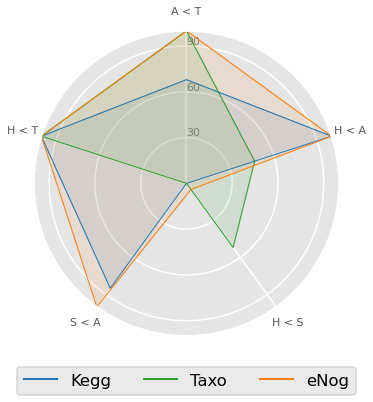

In [23]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import itertools
import matplotlib._color_data as mcd

xkcd = [mcd.XKCD_COLORS["xkcd:" + n] for n in ["lavender", "khaki", "purple"]]
tab = [mcd.TABLEAU_COLORS["tab:" + n] for n in ["blue", "green", "orange"]]


plt.style.use("ggplot")
sns.set_context("talk")
sns.set_palette("tab10")
palette = itertools.cycle(sns.color_palette("tab10"))

# Set data
 
# number of variable
categories=df.columns[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, size=11)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([30, 60, 90], ["30","60","90"], color="grey", size=11)
plt.ylim(0, 100)

 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

for i in range(df.shape[0]):
    values=df.loc[i].drop('Profile').values.flatten().tolist()
    values += values[:1]
    print(values)
    color = next(palette)
    color = tab[i]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.iloc[i, 0], color=color)
    ax.fill(angles, values, alpha=0.1, color=color)
    
# Add legend
leg = plt.legend(loc=8, ncol=3,  bbox_to_anchor=(0.5, -0.22))
# leg = plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1.5))
# set the linewidth of each legend object
# plt.legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
plt.tight_layout()

EXTENSIONS = ["pdf", "png", "svg"]
fig_folder_path = results_path.joinpath("combined")
for ext in EXTENSIONS:
    fname = f"{condition}_adenoma_radar.{ext}"
    fig_path = fig_folder_path.joinpath(
        fname
    )
    plt.savefig(fig_path, dpi=300, bbox_inches="tight", pad_inches=0.01)
#     if ext == "svg":
    plt.savefig(project_path.joinpath("figures", fname), dpi=300, bbox_inches="tight", pad_inches=0.1)
                    
plt.show()
plt.close()

# Signature analysis

In [24]:
results_dict = {}
results = []
condition = "CRC"
for profile_name in ["KEGG_KOs", "centrifuge", "OGs"]:
    name = f"{condition}_{profile_name}_oLOPO_withSignature.jbl"
#     path = results_path.joinpath(f"{condition}_{profile_name}_results".lower(), name)
    path = results_path.joinpath(f"{condition.lower()}_{profile_name.lower()}_results", name)
    if profile_name == "kcentrifuge":
        results[profile_name] = adenoma_mwtest
    else:
        results_dict[profile_name] = joblib.load(path)
        results.append(joblib.load(path))

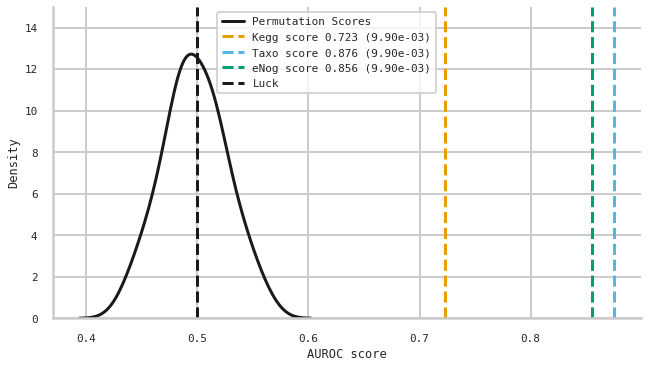

In [25]:
# def plot_significance(results, path, modus="signature", n_classes=2):
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     import pandas as pd

# code extracted from sklearn
n_classes = 2
modus="signature"
path=results_path.joinpath("combined")
sns.set(context="poster", style="whitegrid", font_scale=0.5, font="monospace")
sns.set_palette("colorblind")
plt.style.use('seaborn-colorblind')


colors = ["b", "C1", "g"]
colors=COLOR_BLIND_PALETTE
fac = 1.8
fig, ax = plt.subplots(constrained_layout=True, figsize=(16/fac, 9/fac))

for i, results_i in enumerate(results):
    #color_i = colors[i]
    profile_name = results_i["profile_name"]
    if "centri" in profile_name.lower():
        profile_name = "Taxo"
    elif "ogs" in profile_name.lower():
        profile_name = "eNog"
    elif "kegg" in profile_name.lower():
        profile_name = "Kegg"
    pvalue = results_i["pvalue"]
    permutation_scores = results_i["permutation_scores"]
    score = results_i["score"]

    # plt.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
    if i == 0:
        sns.kdeplot(
            pd.Series(permutation_scores, name="Permutation Scores"), color="k"
        )
    ylim = [0, 15]
    plt.plot(
        2 * [score],
        ylim,
        #f"--{color_i}",
        color=COLOR_BLIND_PALETTE[i+1],
        linestyle="--",
        linewidth=3,
        label=f"{profile_name} score {score:.3f} ({pvalue:.2e})",
    )

plt.plot(2 * [1.0 / n_classes], ylim, "--k", linewidth=3, label="Luck")

plt.ylim(ylim)

plt.xlabel("AUROC score")
plt.ylabel("Density")
# plt.tight_layout()
plt.legend(loc="upper left", bbox_to_anchor=(0.27, 1))

sns.despine()

for ext in ["pdf", "svg", "png"]:
    fname = f"{condition}_{modus}_permutation_analysis.{ext}".lower()
    fpath = path.joinpath(fname)
    plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0.1)
#     if ext=="svg":
    plt.savefig(project_path.joinpath("figures", fname), dpi=300, bbox_inches="tight", pad_inches=0.1)
        
plt.show()